In [1]:
import keras
import tensorflow as tf
import numpy as np
from Bio import SeqIO 
import re

Using TensorFlow backend.


In [2]:
print(tf.__version__)
print(keras.__version__)

1.9.0
2.2.4


In [3]:
import cv2
print(cv2.__version__)

4.2.0


In [4]:
# 显示图像
def showImage(img_array):
    cv2.imshow('image_box',img_array)  # 显示图像('图像名称',图像)
    cv2.waitKey(0)  # 保持窗口的显示
    cv2.destroyAllWindows()  # 销毁所有窗口

In [5]:
def getMaskedImg(original_img):
    # lower mask (0-10)
    lower_red = np.array([0,50,50])  # 低于这个lower_red的值，图像值变为0
    upper_red = np.array([10,255,255])  # 高于这个upper_red的值，图像值变为0 
    mask0 = cv2.inRange(original_img, lower_red, upper_red)

    # upper mask (170-180)
    lower_red = np.array([170,50,50])
    upper_red = np.array([180,255,255])
    mask1 = cv2.inRange(original_img, lower_red, upper_red)

    # join my masks
    mask = mask0 + mask1

    # set my output img to zero everywhere except my mask
    output_img = original_img.copy()
    output_img[np.where(mask==0)] = 0
    
    return output_img

In [6]:
# 读入图片
def readImg(img_path):
    img = cv2.imread(img_path)
    return img

In [7]:
def getEdgesFromInnerImg(original_img):
    
    rows, cols, color_space = img.shape
    
    valid_rows = []
    valid_cols = []
    for i in range(rows):
        if all(original_img[i][228] != [255,255,255]):
            valid_rows.append(i)

    for j in range(cols):
        if all(original_img[149][j] != [255,255,255]):
            valid_cols.append(j)

    print("UpperLeft - row: ", min(valid_rows), "col: ", min(valid_cols))
    print("UpperRight - row: ", min(valid_rows), "col: ", max(valid_cols))
    print("LowerLeft - row: ", max(valid_rows), "col: ", min(valid_cols))
    print("LowerRight - row: ", max(valid_rows), "col: ", max(valid_cols))

In [8]:
# 通道色彩空间的转换
def convertToHSV(original_img): 
    hsv_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)
    return hsv_img

In [9]:
# 读取序列数据
def make_image(sequence):
    image_array = np.ones((64, 64, 4))
    for k in range(len(sequence)):
        x, y = point_list[k]  # 用(x,y)保存hilbert曲线的绘制顺序
        image_array[x][y] = sequence[k]  # 将坐标映射为图像
    for k in range(len(sequence), len(point_list)):
        x, y = point_list[k]
        image_array[x][y] = np.array([0, 0, 0, 0])
    return image_array

In [10]:
def convertToOriginalCoord(current_coord):
    uppermost_row = 35
    leftmost_col = 113

    original_row = (int)((current_coord[0] - uppermost_row) / 7)
    original_col = (int)((current_coord[1] - leftmost_col) / 7)
    
    return (original_row, original_col)

In [11]:
def getAllOriginalMaskedCoord(masked_pixel):
    
    original_coords = {}
    for pix in masked_pixels:
        org_coord = convertToOriginalCoord(pix)
        original_coords[org_coord] = 1
        
    return original_coords.keys()

In [12]:
# hilbert mapping: co-ordinates with string index
def last_2_bits(x):
    return x & 3

def hindex_to_xy(hindex, N):
    positions = [
                    [0, 0],
                    [0, 1],
                    [1, 1],
                    [1, 0]
                ]

    tmp = positions[last_2_bits(hindex)]
    hindex = hindex >> 2

    # 2. iteratively compute coords
    x = tmp[0]
    y = tmp[1]

    n = 4
    while (n <= N):

        n2 = int(n / 2)
        pos_in_small_square = last_2_bits(hindex)

        if(pos_in_small_square == 0): # lower left
            tmp = x
            x = y
            y = tmp
        elif(pos_in_small_square == 1): # upper left
            x = x
            y = y + n2
        elif(pos_in_small_square == 2): # upper right
            x = x + n2
            y = y + n2
        elif(pos_in_small_square == 3): # lower right
            tmp = y
            y = (n2 - 1) - x
            x = (n2 - 1) - tmp
            x = x + n2

        hindex = hindex >> 2
        n *= 2

    return x, y

def map_hilbert_coord_with_index(order):
    N = 2**order
    coord_index_map = {}
    
    for i in range(N*N):
        coord = hindex_to_xy(i, N)
        coord_index_map[coord] = i
        
    return coord_index_map

In [13]:
# our image dimension: 64x64; hilbert order is 6 (2^6 = 64)
coord_index_map = map_hilbert_coord_with_index(6)

In [14]:
def right_pixel(cur_coord):
    row = cur_coord[0]
    col = cur_coord[1] + 1
    if col >= MAX_LEN:
        col = MAX_LEN - 1
    
    return (row, col)

def left_pixel(cur_coord):
    row = cur_coord[0]
    col = cur_coord[1] - 1
    if col < 0:
        col = 0
    
    return (row, col)

def up_pixel(cur_coord):
    row = cur_coord[0] - 1
    col = cur_coord[1]
    if row < 0:
        row = 0
    
    return (row, col)

def down_pixel(cur_coord):
    row = cur_coord[0] + 1
    col = cur_coord[1]
    if row >= MAX_LEN:
        row = MAX_LEN - 1

    return (row, col)

In [15]:
MAX_LEN = 3000
MAX_DIM = 63
def getActivatedIndices(masked_coords, coord_index_map):
    activated_indices = []
    for coord in masked_coords:
        idx = coord_index_map[coord]
        if idx >= MAX_LEN:
            
            if coord[0] >= MAX_DIM:
                coord = (coord[0] - 1, coord[1])
            if coord[1] >= MAX_DIM:
                coord = (coord[0], coord[1] - 1)
            
            # right
            idx = coord_index_map[right_pixel(coord)]
            if idx < MAX_LEN and idx not in activated_indices:
                activated_indices.append(idx)
            # left
            idx = coord_index_map[left_pixel(coord)]
            if idx < MAX_LEN and idx not in activated_indices:
                activated_indices.append(idx)
            # up
            idx = coord_index_map[up_pixel(coord)]
            if idx < MAX_LEN and idx not in activated_indices:
                activated_indices.append(idx)
            # down
            idx = coord_index_map[down_pixel(coord)]
            if idx < MAX_LEN and idx not in activated_indices:
                activated_indices.append(idx)
        else:
            if idx < MAX_LEN and idx not in activated_indices:
                activated_indices.append(idx)
        
    # print(activated_indices)
    activated_indices.sort()
    return activated_indices

In [16]:
def getMaskedPixels(masked_img):
    rows, cols, color_space = masked_img.shape
    
    masked_pixels = []
    for i in range(rows):
        for j in range(cols):
            if any(masked_img[i,j] != 0):
                masked_pixels.append([i,j])
                
    return masked_pixels

In [17]:
import h5py
def load_positive_data(cell):    
    file_name_cell = '../' + cell + '_all_data_hilbert_without_aug.h5'
    with h5py.File(file_name_cell, 'r') as hf:
        dataset_enhancer = np.array(hf.get('enhancers'))
        dataset_promoter = np.array(hf.get('promoters'))
        labels = np.array(hf.get('labels'))

    pos = 0
    for i in range(len(labels)):
        if labels[i] == 1:
            pos += 1

    pos_enh = dataset_enhancer[:pos]
    pos_pro = dataset_promoter[:pos]
    
    return pos_enh,pos_pro

cell = 'IMR90'
pos_enh,pos_pro = load_positive_data(cell)
positive_string_count = len(pos_enh)

In [18]:
# 读取Hilbert编码方式
import re
position = []
for line in open('fantom_point_list.txt',"r"):    #设置文件对象
    x,y = re.findall(r'\d+',line)
    position.append([int(x),int(y)])
len(position)

4096

In [19]:
# 将Hilbert编码后的数据转化为序列形式
def sequence_match(s):
    seq = ""
    res = [int(i) for i in s]
    if res == [1,0,0,0]:
        seq += 'A'
    elif res == [0,1,0,0]:
        seq += 'T'
    elif res == [0,0,1,0]:
        seq += 'C'    
    elif res == [0,0,0,1]:
        seq += 'G'
    return seq

positive_dataset_string = []
for i in range(len(pos_enh)):
    e = pos_enh[i]
    s = ""
    for x,y in position:
        ans = e[x][y]
        s = s + sequence_match(ans)
    positive_dataset_string.append(s)
    
len(positive_dataset_string)

1254

In [20]:
print(len(positive_dataset_string[0]))
positive_dataset_string[0]

3000


'TTGCGGCCGTTGCCGTCCTGGGGGAGGATAATCTATCCCGCCACCCCATGTTTGTGATATCCCATTACTCATCATATTTGTTTTTTTGTTTTTTCTTCAGCTTTTCATTGTTCAACCCCGGTTACTCATTCGCATTACTCCATTTGCATTTCTGTATGTCCTTTTCCCCCGCAAATCCTCTTTTGCCAAATATTCCTCCTTCCCCTTCCCCTCCCGCGTCGCCGCCGCCCCCGCCACCTCCATTCCCTTTGTTCCTCCTCCGCCGCCTAACTCTTCCTCCGCCGCCGCCTAACTGTTCCGCCGCCTAACTCTTCCTCCGCCGCCGCCTAACTCTTCCTCCGCCGCCGCCTAACTGTTCCGCCGCCTAACTGTTCCTCCGCCGCCGCCTAACTGTTCCGCCGCCTAACTCTTCCTCCTCCGCCGCCTAACTCTTCCGCCGCCGCCGCCTAACTCTTCCTCCGCCGCCGCCTAACTGTTCCTCCGCCTAACTGTTCCTCCTCCGCCGCCTAACTGTTCCTCGGCCTCATCTCCCTTCTCATTCCTCACGCCTCCACCATTTTTCTCCACATCGCCGCTCTCCTCCTCCGCCCTCAAACACAAATATCCTCTCTTCCACTACTTCCTCTGTCCCTTATCTCCTTTTGCGGGCCGTTTCGCCAAATGCAATATCGCACTGGCCTTTATTAGCGTGCCTCTTAAAGGCTTGGCGTATCTGCTCCTTACGCCTCCTCTTTTATTCTTTGTATTTTATTTTTCCTTATTTGCTTTTTGTCCTTTTTTGTCTTTAATTCGTCTTTTTATTCGTGGTTTTACTGGCTGTTCTTTTTATTCGTGGTTTTACTGGCTGTTCTTTTTATTCGTGGTTTTACTGGCTGTTCTTTTTATTCGTGGTTTGCCCCGCCCCTCCCCACCTCTGCCCATTTAACCCCTTCATTTCACCCATGTATTTTTTCCCTTTCTGCCTCCCAGGCCGCACGTCGTGCCCCTCCGTGTCCCTAA

In [116]:
# our image dimension: 64x64; hilbert order is 6 (2^6 = 64)
MAX_LEN = 3000
coord_index_map = map_hilbert_coord_with_index(6)
drawn_heatmap = 1254
cell = 'IMR90'

activated_seq_list = []
for i in range (0, drawn_heatmap-1):
    
    print("Processing Sequence: ", i)
    img_path = "heatmaps/" + cell + "/heatmap_pos_enh_" + str(i) + ".png"
    
    seq = positive_dataset_string[i]
    img = readImg(img_path)  # 读取文件路径
    
    hsv_img = convertToHSV(img)
    masked_img = getMaskedImg(hsv_img)
    masked_pixels = getMaskedPixels(masked_img)
    masked_coords = getAllOriginalMaskedCoord(masked_pixels)
    activated_index_list = getActivatedIndices(masked_coords, coord_index_map)
    
    prevIdx = -1
    activated_seq = ''
    for idx in activated_index_list:        

        if prevIdx != -1 and idx - prevIdx > 1:
            activated_seq += "-" + str(idx - prevIdx) + "-"

        activated_seq += seq[idx]
        prevIdx = idx

    activated_seq_list.append(activated_seq.upper())
    

Processing Sequence:  0
Processing Sequence:  1
Processing Sequence:  2
Processing Sequence:  3
Processing Sequence:  4
Processing Sequence:  5
Processing Sequence:  6
Processing Sequence:  7
Processing Sequence:  8
Processing Sequence:  9
Processing Sequence:  10
Processing Sequence:  11
Processing Sequence:  12
Processing Sequence:  13
Processing Sequence:  14
Processing Sequence:  15
Processing Sequence:  16
Processing Sequence:  17
Processing Sequence:  18
Processing Sequence:  19
Processing Sequence:  20
Processing Sequence:  21
Processing Sequence:  22
Processing Sequence:  23
Processing Sequence:  24
Processing Sequence:  25
Processing Sequence:  26
Processing Sequence:  27
Processing Sequence:  28
Processing Sequence:  29
Processing Sequence:  30
Processing Sequence:  31
Processing Sequence:  32
Processing Sequence:  33
Processing Sequence:  34
Processing Sequence:  35
Processing Sequence:  36
Processing Sequence:  37
Processing Sequence:  38
Processing Sequence:  39
Processing

Processing Sequence:  320
Processing Sequence:  321
Processing Sequence:  322
Processing Sequence:  323
Processing Sequence:  324
Processing Sequence:  325
Processing Sequence:  326
Processing Sequence:  327
Processing Sequence:  328
Processing Sequence:  329
Processing Sequence:  330
Processing Sequence:  331
Processing Sequence:  332
Processing Sequence:  333
Processing Sequence:  334
Processing Sequence:  335
Processing Sequence:  336
Processing Sequence:  337
Processing Sequence:  338
Processing Sequence:  339
Processing Sequence:  340
Processing Sequence:  341
Processing Sequence:  342
Processing Sequence:  343
Processing Sequence:  344
Processing Sequence:  345
Processing Sequence:  346
Processing Sequence:  347
Processing Sequence:  348
Processing Sequence:  349
Processing Sequence:  350
Processing Sequence:  351
Processing Sequence:  352
Processing Sequence:  353
Processing Sequence:  354
Processing Sequence:  355
Processing Sequence:  356
Processing Sequence:  357
Processing S

Processing Sequence:  636
Processing Sequence:  637
Processing Sequence:  638
Processing Sequence:  639
Processing Sequence:  640
Processing Sequence:  641
Processing Sequence:  642
Processing Sequence:  643
Processing Sequence:  644
Processing Sequence:  645
Processing Sequence:  646
Processing Sequence:  647
Processing Sequence:  648
Processing Sequence:  649
Processing Sequence:  650
Processing Sequence:  651
Processing Sequence:  652
Processing Sequence:  653
Processing Sequence:  654
Processing Sequence:  655
Processing Sequence:  656
Processing Sequence:  657
Processing Sequence:  658
Processing Sequence:  659
Processing Sequence:  660
Processing Sequence:  661
Processing Sequence:  662
Processing Sequence:  663
Processing Sequence:  664
Processing Sequence:  665
Processing Sequence:  666
Processing Sequence:  667
Processing Sequence:  668
Processing Sequence:  669
Processing Sequence:  670
Processing Sequence:  671
Processing Sequence:  672
Processing Sequence:  673
Processing S

Processing Sequence:  952
Processing Sequence:  953
Processing Sequence:  954
Processing Sequence:  955
Processing Sequence:  956
Processing Sequence:  957
Processing Sequence:  958
Processing Sequence:  959
Processing Sequence:  960
Processing Sequence:  961
Processing Sequence:  962
Processing Sequence:  963
Processing Sequence:  964
Processing Sequence:  965
Processing Sequence:  966
Processing Sequence:  967
Processing Sequence:  968
Processing Sequence:  969
Processing Sequence:  970
Processing Sequence:  971
Processing Sequence:  972
Processing Sequence:  973
Processing Sequence:  974
Processing Sequence:  975
Processing Sequence:  976
Processing Sequence:  977
Processing Sequence:  978
Processing Sequence:  979
Processing Sequence:  980
Processing Sequence:  981
Processing Sequence:  982
Processing Sequence:  983
Processing Sequence:  984
Processing Sequence:  985
Processing Sequence:  986
Processing Sequence:  987
Processing Sequence:  988
Processing Sequence:  989
Processing S

In [117]:
print(len(activated_seq_list))

1253


In [118]:
with open("activated_subsequence_list_with_gap_enh.txt", "w") as file:
    for seq in activated_seq_list:
        file.write(seq + "\n")

In [34]:
#启动子序列提取
MAX_LEN = 2000
MAX_DIM = 63

positive_dataset_string_pro = []
for i in range(len(pos_pro)):
    p = pos_pro[i]
    s = ""
    for x,y in position:
        ans = p[x][y]
        s = s + sequence_match(ans)
    positive_dataset_string_pro.append(s)
    
len(positive_dataset_string_pro)

1254

In [37]:
print(len(positive_dataset_string_pro[0]))
positive_dataset_string_pro[0]

2000


'GCCCTCCTCTCCCTCATCCCACCCTTCTCGCCTAATTCACTCTCCGTCTATTACTCCATACGTCAACTTCTTTTCGCCGAGTCAAATATCGCCCACAAAGCAACAAGAAAAATCATTTATGCCATGTTAAAACTCTATTTTCATGTTTAACCTCACGTAGTGCTCCATCGCTACAAAATACTTTCTACCCTATTTCCATTCGTTCGGCTCCGCCTAGCCTCTTATACCTTTCCATCTCCACTAACACCACTCATTTCTCGCCCCTGCCAGTTCCCGCGTTTGTCCTACCTCTTCGCGGCCCTTTTACTCCTCACTTTACTAATACTTGTTTTATTCCTTCTCCGGCCGGCCCTCGACCATCCGTACACCCTTTCCCCCTTTCCGTTACATCCATACCCCTCTACAATTTCTCCTCTTTTCTCATTCACTTCGCCCCCATCCCGTTCTCGTATTTTTCTCTGTATTCTAACACTTTCTTAGGTTCCGCTTTTGCCCAGGCTACGGCGGTTGTCCTCTTTTCCCCTTTTCGCCCCTTATTATATCAATGGATTTTTGCTTTTTATCTTTTAGTTCGGCCTTTTTATTATTATTTCTATTCCGTTTTTTCGCCGCTTATTATTAATATTTCTATTCGGATTTTTTCGCCGGTTATTATTATTATTTCTATTCGGATTATTTCGCGGCTTATAAACATTATTTCTATTCCGTGTTTTTTCGGCCCTTTTAATAATTAATTCTATACCGATTTTTTCGGCCCTTATTATTATTATTATTATTTCGATTCCTTTTTCGGCCCATATTATTATTAGTTCTTTTCCGTTTTTTCGGCGCTTATAATTAATAGTTCTATTCCGATTTTTTCGGCGCTTATTATTATTATTTCTATTCCGTTGTTTTTTCGGCCCTTATTATTATTAGTTCTTTTGCGTTTTTGTCGGCGCTTATTATTATTCTTACCCTTTTCTCATCTCGTTAATAAGCCTCTGCCAACTGCGATGC

In [38]:
MAX_LEN = 2000
coord_index_map = map_hilbert_coord_with_index(6)
drawn_heatmap = 1254
cell = 'IMR90'

activated_seq_list = []
for i in range (0, drawn_heatmap-1):
    
    print("Processing Pro Sequence: ", i)
    img_path = "heatmaps/" + cell + "/heatmap_pos_pro_" + str(i) + ".png"
    
    seq = positive_dataset_string_pro[i]
    img = readImg(img_path)  # 读取文件路径
    
    hsv_img = convertToHSV(img)
    masked_img = getMaskedImg(hsv_img)
    masked_pixels = getMaskedPixels(masked_img)
    masked_coords = getAllOriginalMaskedCoord(masked_pixels)
    activated_index_list = getActivatedIndices(masked_coords, coord_index_map)
    
    prevIdx = -1
    activated_seq = ''
    for idx in activated_index_list:        

        if prevIdx != -1 and idx - prevIdx > 1:
            activated_seq += "-" + str(idx - prevIdx) + "-"

        activated_seq += seq[idx]
        prevIdx = idx

    activated_seq_list.append(activated_seq.upper())

Processing Pro Sequence:  0
Processing Pro Sequence:  1
Processing Pro Sequence:  2
Processing Pro Sequence:  3
Processing Pro Sequence:  4
Processing Pro Sequence:  5
Processing Pro Sequence:  6
Processing Pro Sequence:  7
Processing Pro Sequence:  8
Processing Pro Sequence:  9
Processing Pro Sequence:  10
Processing Pro Sequence:  11
Processing Pro Sequence:  12
Processing Pro Sequence:  13
Processing Pro Sequence:  14
Processing Pro Sequence:  15
Processing Pro Sequence:  16
Processing Pro Sequence:  17
Processing Pro Sequence:  18
Processing Pro Sequence:  19
Processing Pro Sequence:  20
Processing Pro Sequence:  21
Processing Pro Sequence:  22
Processing Pro Sequence:  23
Processing Pro Sequence:  24
Processing Pro Sequence:  25
Processing Pro Sequence:  26
Processing Pro Sequence:  27
Processing Pro Sequence:  28
Processing Pro Sequence:  29
Processing Pro Sequence:  30
Processing Pro Sequence:  31
Processing Pro Sequence:  32
Processing Pro Sequence:  33
Processing Pro Sequence:

Processing Pro Sequence:  277
Processing Pro Sequence:  278
Processing Pro Sequence:  279
Processing Pro Sequence:  280
Processing Pro Sequence:  281
Processing Pro Sequence:  282
Processing Pro Sequence:  283
Processing Pro Sequence:  284
Processing Pro Sequence:  285
Processing Pro Sequence:  286
Processing Pro Sequence:  287
Processing Pro Sequence:  288
Processing Pro Sequence:  289
Processing Pro Sequence:  290
Processing Pro Sequence:  291
Processing Pro Sequence:  292
Processing Pro Sequence:  293
Processing Pro Sequence:  294
Processing Pro Sequence:  295
Processing Pro Sequence:  296
Processing Pro Sequence:  297
Processing Pro Sequence:  298
Processing Pro Sequence:  299
Processing Pro Sequence:  300
Processing Pro Sequence:  301
Processing Pro Sequence:  302
Processing Pro Sequence:  303
Processing Pro Sequence:  304
Processing Pro Sequence:  305
Processing Pro Sequence:  306
Processing Pro Sequence:  307
Processing Pro Sequence:  308
Processing Pro Sequence:  309
Processing

Processing Pro Sequence:  551
Processing Pro Sequence:  552
Processing Pro Sequence:  553
Processing Pro Sequence:  554
Processing Pro Sequence:  555
Processing Pro Sequence:  556
Processing Pro Sequence:  557
Processing Pro Sequence:  558
Processing Pro Sequence:  559
Processing Pro Sequence:  560
Processing Pro Sequence:  561
Processing Pro Sequence:  562
Processing Pro Sequence:  563
Processing Pro Sequence:  564
Processing Pro Sequence:  565
Processing Pro Sequence:  566
Processing Pro Sequence:  567
Processing Pro Sequence:  568
Processing Pro Sequence:  569
Processing Pro Sequence:  570
Processing Pro Sequence:  571
Processing Pro Sequence:  572
Processing Pro Sequence:  573
Processing Pro Sequence:  574
Processing Pro Sequence:  575
Processing Pro Sequence:  576
Processing Pro Sequence:  577
Processing Pro Sequence:  578
Processing Pro Sequence:  579
Processing Pro Sequence:  580
Processing Pro Sequence:  581
Processing Pro Sequence:  582
Processing Pro Sequence:  583
Processing

Processing Pro Sequence:  825
Processing Pro Sequence:  826
Processing Pro Sequence:  827
Processing Pro Sequence:  828
Processing Pro Sequence:  829
Processing Pro Sequence:  830
Processing Pro Sequence:  831
Processing Pro Sequence:  832
Processing Pro Sequence:  833
Processing Pro Sequence:  834
Processing Pro Sequence:  835
Processing Pro Sequence:  836
Processing Pro Sequence:  837
Processing Pro Sequence:  838
Processing Pro Sequence:  839
Processing Pro Sequence:  840
Processing Pro Sequence:  841
Processing Pro Sequence:  842
Processing Pro Sequence:  843
Processing Pro Sequence:  844
Processing Pro Sequence:  845
Processing Pro Sequence:  846
Processing Pro Sequence:  847
Processing Pro Sequence:  848
Processing Pro Sequence:  849
Processing Pro Sequence:  850
Processing Pro Sequence:  851
Processing Pro Sequence:  852
Processing Pro Sequence:  853
Processing Pro Sequence:  854
Processing Pro Sequence:  855
Processing Pro Sequence:  856
Processing Pro Sequence:  857
Processing

Processing Pro Sequence:  1095
Processing Pro Sequence:  1096
Processing Pro Sequence:  1097
Processing Pro Sequence:  1098
Processing Pro Sequence:  1099
Processing Pro Sequence:  1100
Processing Pro Sequence:  1101
Processing Pro Sequence:  1102
Processing Pro Sequence:  1103
Processing Pro Sequence:  1104
Processing Pro Sequence:  1105
Processing Pro Sequence:  1106
Processing Pro Sequence:  1107
Processing Pro Sequence:  1108
Processing Pro Sequence:  1109
Processing Pro Sequence:  1110
Processing Pro Sequence:  1111
Processing Pro Sequence:  1112
Processing Pro Sequence:  1113
Processing Pro Sequence:  1114
Processing Pro Sequence:  1115
Processing Pro Sequence:  1116
Processing Pro Sequence:  1117
Processing Pro Sequence:  1118
Processing Pro Sequence:  1119
Processing Pro Sequence:  1120
Processing Pro Sequence:  1121
Processing Pro Sequence:  1122
Processing Pro Sequence:  1123
Processing Pro Sequence:  1124
Processing Pro Sequence:  1125
Processing Pro Sequence:  1126
Processi

In [39]:
print(len(activated_seq_list))
with open("activated_subsequence_list_with_gap_pro.txt", "w") as file:
    for seq in activated_seq_list:
        file.write(seq + "\n")

1253


In [ ]:
# *****************************************************
# NEXT:
#     commonSubstringFromActivatedStrings.ipynb
# *****************************************************

In [21]:
# our image dimension: 64x64; hilbert order is 6 (2^6 = 64)
MAX_LEN = 3000
coord_index_map = map_hilbert_coord_with_index(6)
drawn_heatmap = 1254
cell = 'IMR90'

activated_seq_list = []
i=0
    
print("Processing Sequence: ", i)
img_path = "heatmaps/" + cell + "/heatmap_pos_enh_" + str(i) + ".png"

seq = positive_dataset_string[i]
img = readImg(img_path)  # 读取文件路径

print(seq)
print(img)

Processing Sequence:  0
TTGCGGCCGTTGCCGTCCTGGGGGAGGATAATCTATCCCGCCACCCCATGTTTGTGATATCCCATTACTCATCATATTTGTTTTTTTGTTTTTTCTTCAGCTTTTCATTGTTCAACCCCGGTTACTCATTCGCATTACTCCATTTGCATTTCTGTATGTCCTTTTCCCCCGCAAATCCTCTTTTGCCAAATATTCCTCCTTCCCCTTCCCCTCCCGCGTCGCCGCCGCCCCCGCCACCTCCATTCCCTTTGTTCCTCCTCCGCCGCCTAACTCTTCCTCCGCCGCCGCCTAACTGTTCCGCCGCCTAACTCTTCCTCCGCCGCCGCCTAACTCTTCCTCCGCCGCCGCCTAACTGTTCCGCCGCCTAACTGTTCCTCCGCCGCCGCCTAACTGTTCCGCCGCCTAACTCTTCCTCCTCCGCCGCCTAACTCTTCCGCCGCCGCCGCCTAACTCTTCCTCCGCCGCCGCCTAACTGTTCCTCCGCCTAACTGTTCCTCCTCCGCCGCCTAACTGTTCCTCGGCCTCATCTCCCTTCTCATTCCTCACGCCTCCACCATTTTTCTCCACATCGCCGCTCTCCTCCTCCGCCCTCAAACACAAATATCCTCTCTTCCACTACTTCCTCTGTCCCTTATCTCCTTTTGCGGGCCGTTTCGCCAAATGCAATATCGCACTGGCCTTTATTAGCGTGCCTCTTAAAGGCTTGGCGTATCTGCTCCTTACGCCTCCTCTTTTATTCTTTGTATTTTATTTTTCCTTATTTGCTTTTTGTCCTTTTTTGTCTTTAATTCGTCTTTTTATTCGTGGTTTTACTGGCTGTTCTTTTTATTCGTGGTTTTACTGGCTGTTCTTTTTATTCGTGGTTTTACTGGCTGTTCTTTTTATTCGTGGTTTGCCCCGCCCCTCCCCACCTCTGCCCATTTAACCCCTTCATTTCACCCATGTATTTTTTCCCTTTCTGCCTCCCAGGCCGCAC

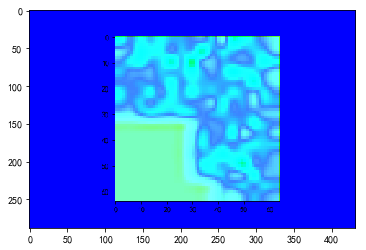

In [23]:
import matplotlib.pyplot as plt

hsv_img = convertToHSV(img)
plt.imshow(hsv_img)
plt.show()

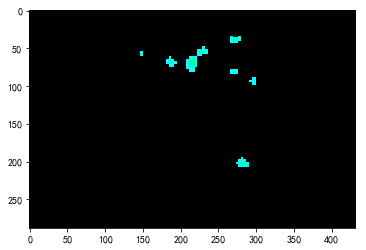

In [24]:
masked_img = getMaskedImg(hsv_img)
plt.imshow(masked_img)
plt.show()

In [26]:
masked_pixels = getMaskedPixels(masked_img)
masked_coords = getAllOriginalMaskedCoord(masked_pixels)
activated_index_list = getActivatedIndices(masked_coords, coord_index_map)

In [32]:
masked_pixels  # 纵轴/横轴

[[35, 266],
 [35, 267],
 [35, 268],
 [35, 269],
 [35, 276],
 [35, 277],
 [35, 278],
 [35, 279],
 [36, 266],
 [36, 267],
 [36, 268],
 [36, 269],
 [36, 270],
 [36, 271],
 [36, 272],
 [36, 273],
 [36, 274],
 [36, 275],
 [36, 276],
 [36, 277],
 [36, 278],
 [36, 279],
 [37, 266],
 [37, 267],
 [37, 268],
 [37, 269],
 [37, 270],
 [37, 271],
 [37, 272],
 [37, 273],
 [37, 274],
 [37, 275],
 [37, 276],
 [37, 277],
 [37, 278],
 [37, 279],
 [38, 266],
 [38, 267],
 [38, 268],
 [38, 269],
 [38, 270],
 [38, 271],
 [38, 272],
 [38, 273],
 [38, 274],
 [38, 275],
 [38, 276],
 [38, 277],
 [38, 278],
 [38, 279],
 [39, 266],
 [39, 267],
 [39, 268],
 [39, 269],
 [39, 270],
 [39, 271],
 [39, 272],
 [39, 273],
 [39, 274],
 [39, 275],
 [39, 276],
 [39, 277],
 [39, 278],
 [39, 279],
 [40, 266],
 [40, 267],
 [40, 268],
 [40, 269],
 [40, 270],
 [40, 271],
 [40, 272],
 [40, 273],
 [40, 274],
 [40, 275],
 [40, 276],
 [40, 277],
 [40, 278],
 [40, 279],
 [41, 266],
 [41, 267],
 [41, 268],
 [41, 269],
 [41, 270],
 [41

In [28]:
masked_coords

dict_keys([(0, 21), (0, 22), (0, 23), (1, 21), (1, 22), (1, 23), (1, 16), (2, 16), (2, 15), (2, 17), (2, 4), (2, 5), (3, 4), (3, 5), (3, 15), (3, 16), (3, 17), (3, 10), (3, 14), (4, 10), (4, 14), (4, 15), (4, 9), (4, 11), (4, 13), (5, 9), (5, 10), (5, 11), (5, 13), (5, 14), (5, 15), (6, 13), (6, 14), (6, 15), (6, 21), (6, 22), (6, 23), (7, 21), (7, 22), (7, 23), (7, 25), (7, 26), (8, 25), (8, 26), (9, 25), (9, 26), (22, 23), (22, 24), (23, 23), (23, 24), (23, 22), (23, 25), (24, 22), (24, 23), (24, 24), (24, 25)])

In [29]:
activated_index_list

[52,
 53,
 54,
 55,
 73,
 89,
 90,
 91,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 109,
 116,
 117,
 118,
 119,
 120,
 121,
 553,
 554,
 555,
 636,
 639,
 640,
 643,
 724,
 725,
 726,
 806,
 807,
 808,
 809,
 896,
 897,
 898,
 899,
 909,
 910,
 932,
 933,
 934,
 935,
 937,
 945,
 946,
 956,
 957,
 958,
 959,
 982,
 985]

In [30]:
prevIdx = -1
activated_seq = ''
for idx in activated_index_list:        

    if prevIdx != -1 and idx - prevIdx > 1:
        activated_seq += "-" + str(idx - prevIdx) + "-"

    activated_seq += seq[idx]
    prevIdx = idx  # 73 - 55 = 18

activated_seq_list.append(activated_seq.upper())

In [31]:
activated_seq_list

['TGTG-18-A-16-TTT-7-AGCTTTTC-4-G-7-CCCGGT-432-CCA-81-T-3-TT-3-G-81-CCT-80-GTTT-87-CCCG-10-AC-22-ATTT-2-A-8-AT-10-TTCT-23-C-3-C']